
# Value at Risk (VaR) - 历史模拟法演示

📌 本 notebook 用于演示如何使用 Python 进行 VaR（风险价值）计算，
以等权重的债券ETF组合为例，利用历史模拟法估算 1-day 95% 的 VaR。


In [188]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## 1️⃣ 设置组合成分

- EMHY: iShares J.P. Morgan EM High Yield Bond ETF  
- HYEM: VanEck EM High Yield Bond ETF  
- EMB: iShares J.P. Morgan USD EM Bond ETF  
- PCY: Invesco EM Sovereign Debt ETF  
- EMLC: VanEck J.P. Morgan EM Local Currency Bond ETF


In [190]:
tickers = ['EMHY', 'HYEM', 'EMB', 'PCY', 'EMLC']

## 2️⃣ 下载近三年的日收盘价

In [192]:
raw = yf.download(tickers, start='2022-08-01', end='2025-07-01', progress=False)
prices = raw['Close']
prices.columns.name = None  # 移除列名多层索引，使 DataFrame 更清晰
prices.head()

,EMB,EMHY,EMLC,HYEM,PCY
Date,,,,,
2022-08-01,75.716820,28.709200,20.372950,14.689295,15.928358
2022-08-02,74.616356,28.389482,20.130426,14.515113,15.666430
2022-08-03,76.052124,28.873152,20.339500,14.730770,16.018394
2022-08-04,76.215485,28.946945,20.464951,14.714176,16.018394
2022-08-05,76.060715,28.971525,20.331142,14.722476,16.010201


## 3️⃣ 检查缺失值并处理

In [194]:
if prices.isna().sum().sum() > 0:
    print("⚠️ 存在缺失值，进行前向填充...")
    prices = prices.fillna(method='ffill')

## 4️⃣ 计算每日对数收益率

In [196]:
returns = prices.pct_change().dropna()
returns.head()

,EMB,EMHY,EMLC,HYEM,PCY
Date,,,,,
2022-08-02,-0.014534,-0.011136,-0.011904,-0.011858,-0.016444
2022-08-03,0.019242,0.017037,0.010386,0.014857,0.022466
2022-08-04,0.002148,0.002556,0.006168,-0.001126,0.000000
2022-08-05,-0.002031,0.000849,-0.006538,0.000564,-0.000512
2022-08-08,0.014807,0.015564,0.006993,0.006760,0.017383


## 5️⃣ 设置组合权重并计算组合收益

In [198]:
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
portfolio_ret = returns.dot(weights)
portfolio_ret.head()

Date
2022-08-02   -0.013175
2022-08-03    0.016798
2022-08-04    0.001949
2022-08-05   -0.001533
2022-08-08    0.012301
dtype: float64

## 6️⃣ 使用历史模拟法计算 VaR

In [200]:
confidence = 0.95
var_95 = np.percentile(portfolio_ret, (1 - confidence) * 100)

portfolio_value = 10_000_000  # 示例：1000 万美元
dollar_var = portfolio_value * var_95

print(f"\n📉 1-day 95% VaR (历史模拟法): {var_95:.4%}")
print(f"💰 名义 VaR（对应 1000 万美元组合）: ${dollar_var:,.0f}\n")


📉 1-day 95% VaR (历史模拟法): -0.8923%
💰 名义 VaR（对应 1000 万美元组合）: $-89,226



## 7️⃣ 可视化：每日收益率分布与 VaR

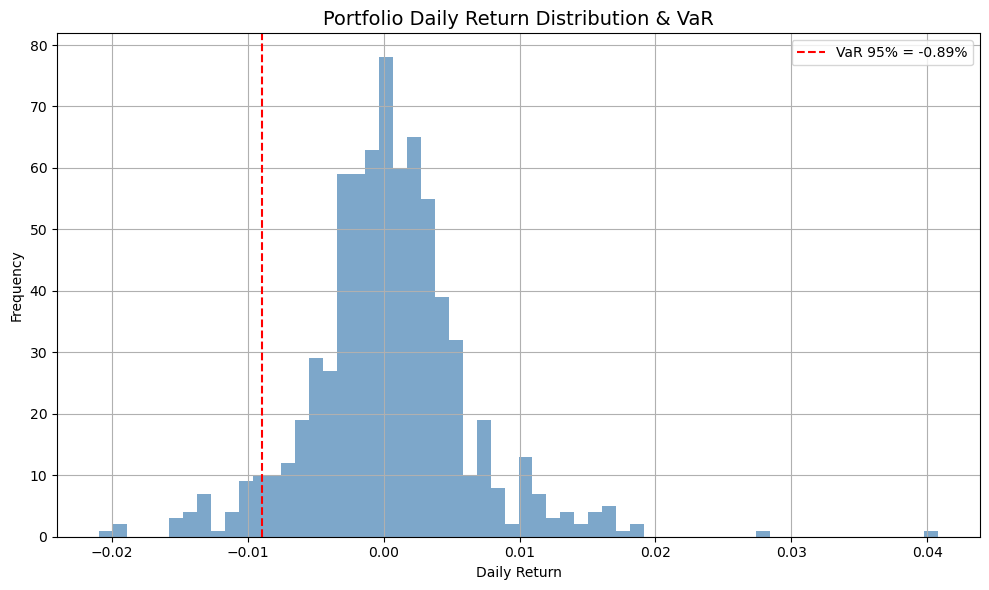

In [202]:
plt.figure(figsize=(10,6))
plt.hist(portfolio_ret, bins=60, color='steelblue', alpha=0.7)
plt.axvline(var_95, color='red', linestyle='--', label=f'VaR 95% = {var_95:.2%}')
plt.title('Portfolio Daily Return Distribution & VaR', fontsize=14)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()